In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import json
import io

## Figure 1: Median of Idle Latency 

In [22]:
df = pd.read_csv('data/Idle latency over the years - rtt-max.csv')
df['dtime per 30 days'] = pd.to_datetime(df['dtime per 30 days'], format='%Y-%m-%d')

# Convert time series with index Month
# df.index = df['dtime per 30 days']
# x_dates = df['dtime per 30 days']
# del df['dtime per 30 days']
df.head()

,dtime per 30 days,Idle Latency
0,2010-12-27,NaN
1,2011-01-26,39.425
2,2011-02-25,38.329
3,2011-03-27,37.763
4,2011-04-26,37.797


<Figure size 1200x300 with 0 Axes>

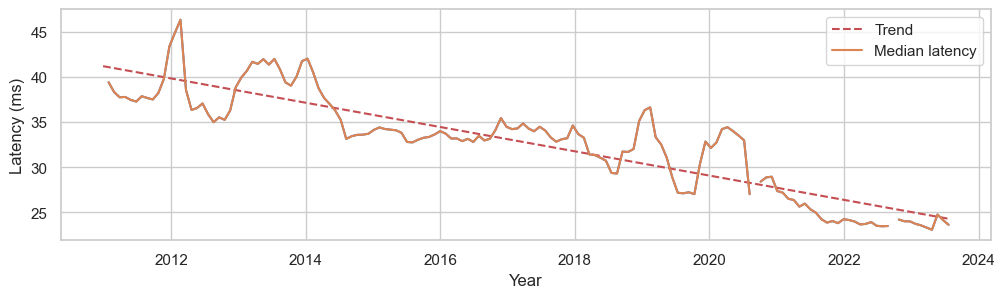

In [23]:
plt.figure(figsize=(12,3))
sns.set_theme(style="whitegrid")

x_dates = df["dtime per 30 days"]
x_num = dates.date2num(x_dates)
y = df['Idle Latency']
idx = np.isfinite(y) & np.isfinite(x_num)

# Calculate fit line
trend = np.polyfit(x_num[idx], y[idx], 1)
fit = np.poly1d(trend)

# General plot again
plt.figure(figsize=(12,3))
plt.plot(x_dates, df['Idle Latency'])
plt.xlabel('Date')
plt.ylabel('Value')
#plt.figure(figsize=(12,3))

# Not really necessary to convert the values back into dates
#but added as a demonstration in case one wants to plot non-linear curves
x_fit = np.linspace(x_num.min(), x_num.max())
sns.set_theme(style="whitegrid")
plt.plot(dates.num2date(x_fit), fit(x_fit), "r--", label="Trend")
plt.plot(x_dates, y, label="Median latency")
plt.ylabel('Latency (ms)')
plt.xlabel('Year')
# plt.title('Median of Idle Latency (rtt_max) Measurements Per Month (2011 - 2023)')
plt.legend(loc="best")
plt.xlabel('Year')

# And show
plt.show()

## Figure 2: Median of Idle Latency by technology

In [14]:
df = pd.read_csv('data/Idle Latency over the years by technology - rtt-max.csv')
df['dtime per 30 days'] = pd.to_datetime(df['dtime per 30 days'], format='%Y-%m-%d')
df.head()

,Top 3 values of operator_technology,dtime per 30 days,Median Latency (ms)
0,Cable,2010-12-27,NaN
1,Cable,2011-01-26,40.324
2,Cable,2011-02-25,39.047
3,Cable,2011-03-27,38.450
4,Cable,2011-04-26,37.869


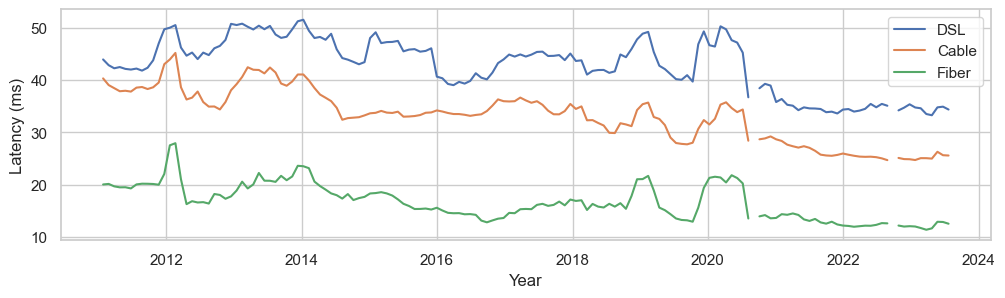

In [15]:
# General plot again
plt.figure(figsize=(12,3))
sns.set_theme(style="whitegrid")

for tech in ["DSL", "Cable", "Fiber"]:
    temp_df = df[df["Top 3 values of operator_technology"] == tech]
    x_dates = temp_df["dtime per 30 days"]
    x_num = dates.date2num(x_dates)
    y = temp_df['Median Latency (ms)']
    idx = np.isfinite(y) & np.isfinite(x_num)
    x_fit = np.linspace(x_num.min(), x_num.max())

    # Calculate fit line
    # trend = np.polyfit(x_num[idx], y[idx], 2)
    # fit = np.poly1d(trend)


    # plt.plot(dates.num2date(x_fit), fit(x_fit), "r--", label=f"{tech} Trend")
    plt.plot(x_dates, y, label=f"{tech}")

plt.ylabel('Latency (ms)')
plt.xlabel('Year')
# plt.title(f"Median of Idle Latency Measurements Per Month by Technology (2011 – 2023)")
plt.legend(loc="best")
# And show
plt.show()

In [16]:
def plot_median_by_tech(tech):
    temp_df = df[df["Top 3 values of operator_technology"] == tech]
    x_dates = temp_df["dtime per 30 days"]
    x_num = dates.date2num(x_dates)
    y = temp_df['Median Latency (ms)']
    idx = np.isfinite(y) & np.isfinite(x_num)

    # Calculate fit line
    trend = np.polyfit(x_num[idx], y[idx], 2)
    fit = np.poly1d(trend)

    # General plot again
    plt.figure(figsize=(12,3))

    x_fit = np.linspace(x_num.min(), x_num.max())
    sns.set_theme(style="whitegrid")
    plt.plot(dates.num2date(x_fit), fit(x_fit), "r--", label="Trend")
    plt.plot(x_dates, y, label="Median latency")
    plt.ylabel('Latency (ms)')
    plt.xlabel('Year')
    plt.title(f"Median of Idle Latency Measurements Per Month (2011 - 2023) for {tech}")
    plt.legend(loc="best")
    plt.xlabel('Year')

    # And show
    plt.show()

### Cable

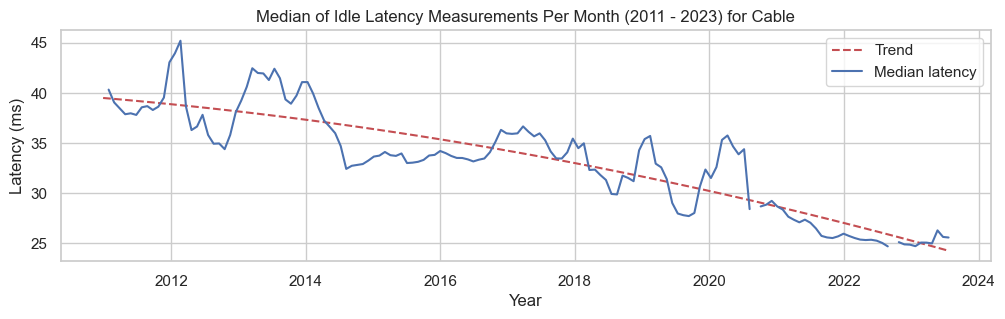

In [17]:
plot_median_by_tech("Cable")

### Fiber

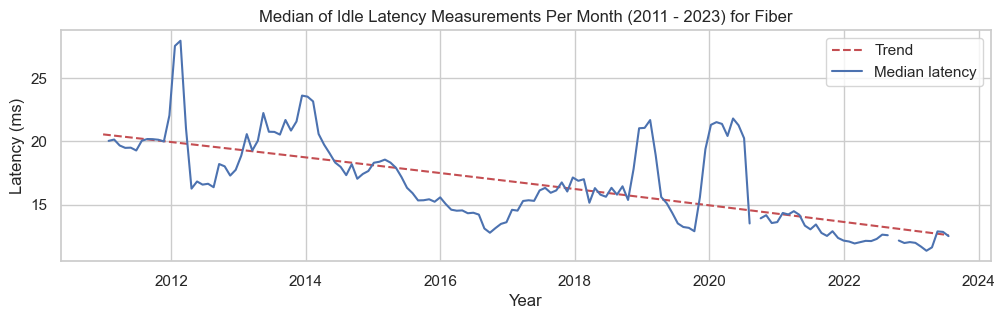

In [18]:
plot_median_by_tech("Fiber")

### DSL

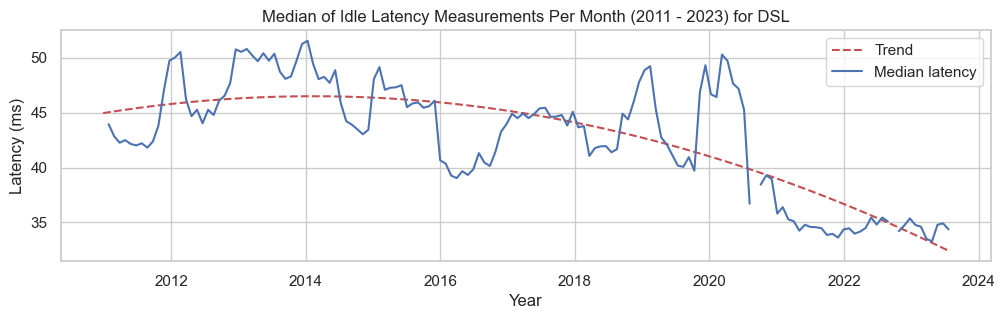

In [19]:
plot_median_by_tech("DSL")

## Figure 3: CDF of Idle Latency

In [16]:
all_info = []
with open("data/CDF of Idle Latency.json", "r") as f:
    data = json.load(f)
for tech_data in data.get("aggregations", '').get("terms", '').get("buckets", ''):
    for pc_info in tech_data.get("cdf", '').get("values", ''):
        all_info.append([tech_data.get("key", ""), pc_info.get("key", ""), pc_info.get("value", "")])

df = pd.DataFrame(all_info, columns=["technology", "percentiles", "latency"])
df["latency"] = df["latency"] / 1000


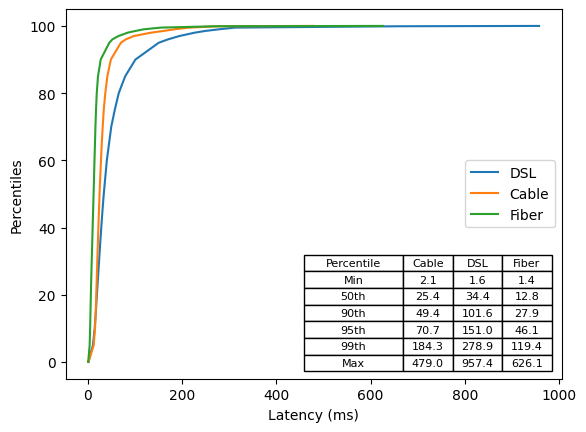

In [17]:
new_df = df[df.percentiles.isin([0, 50, 90, 95, 99, 100])]
new_df = new_df.sort_values(by="technology", ascending=True)
new_df = new_df.round({'latency': 1})

table_data = [
    ['Min'] + new_df[new_df["percentiles"]==0]["latency"].tolist(),
    ['50th'] + new_df[new_df["percentiles"]==50]["latency"].tolist(),
    ['90th'] + new_df[new_df["percentiles"]==90]["latency"].tolist(),
    ['95th'] + new_df[new_df["percentiles"]==95]["latency"].tolist(),
    ['99th'] + new_df[new_df["percentiles"]==99]["latency"].tolist(),
    ['Max'] + new_df[new_df["percentiles"]==100]["latency"].tolist(),
]

# General plot again
# fig, ax1 = plt.figure(figsize=(15,7))
fig, ax1 = plt.subplots()
# fig.set_figure(figsize=(15,7))
# sns.set_theme(style="whitegrid")

for tech in ["DSL", "Cable", "Fiber"]:
    temp_df = df[df["technology"] == tech]
    x_num = temp_df["latency"]
    y = temp_df['percentiles']
    idx = np.isfinite(y) & np.isfinite(x_num)
    x_fit = np.linspace(x_num.min(), x_num.max())
    ax1.plot(x_num, y, label=f"{tech}")

ax1.set_ylabel('Percentiles')
ax1.set_xlabel('Latency (ms)')
ax1.ticklabel_format(style='plain') # prevent scientific notation
# plt.title(f"Median of Idle Latency Measurements Per Month by Technology (2011 – 2023)")

# Create the table within the plot
table = ax1.table(
    cellText=table_data,
    # colLabels=['Percentile', 'Min', '50th', '90th', '95th', '99th', '99.9th', 'Max'],
    colWidths=[0.2, 0.1, 0.1, 0.1],
    colLabels=['Percentile', 'Cable', 'DSL', 'Fiber'],
    loc='lower right',
    cellLoc='center'
)
table.scale(1, 1)
table.auto_set_font_size(False)  # Prevent automatic font resizing
table.set_fontsize(8)  # Adjust font size as needed

plt.legend(loc="center right")
# And show
plt.show()

## Figure 4: Percentage of data less than 100ms for Idle Latency

In [26]:
df = pd.read_csv('data/Percentage of data less than 100 ms - Idle latency.csv')
df['dtime per 30 days'] = pd.to_datetime(df['dtime per 30 days'], format='%Y-%m-%d')
df['Percentage'] = df['Percentage'].str.replace("%","").astype(float)
df.head()

,Top 3 values of operator_technology,dtime per 30 days,Percentage
0,Cable,2010-12-27,NaN
1,Cable,2011-01-26,95.92
2,Cable,2011-02-25,96.69
3,Cable,2011-03-27,96.97
4,Cable,2011-04-26,97.54


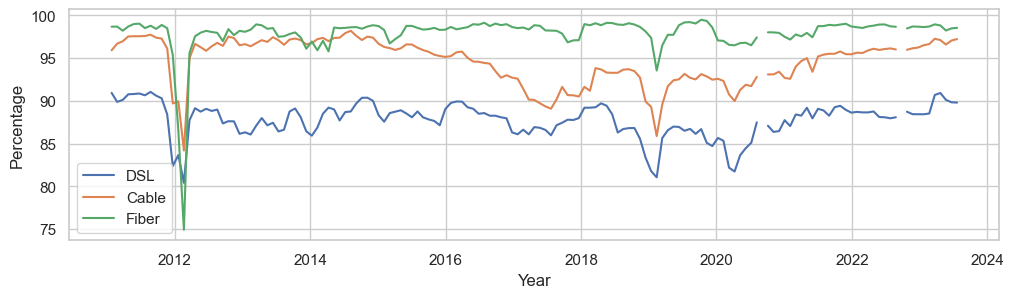

In [27]:
# General plot again
plt.figure(figsize=(12,3))
sns.set_theme(style="whitegrid")

for tech in ["DSL", "Cable", "Fiber"]:
    temp_df = df[df["Top 3 values of operator_technology"] == tech]
    x_dates = temp_df["dtime per 30 days"]
    x_num = dates.date2num(x_dates)
    y = temp_df['Percentage']
    idx = np.isfinite(y) & np.isfinite(x_num)
    x_fit = np.linspace(x_num.min(), x_num.max())

    # Calculate fit line
    # trend = np.polyfit(x_num[idx], y[idx], 2)
    # fit = np.poly1d(trend)


    # plt.plot(dates.num2date(x_fit), fit(x_fit), "r--", label=f"{tech} Trend")
    plt.plot(x_dates, y, label=f"{tech}")

plt.ylabel('Percentage')
plt.xlabel('Year')
# plt.title(f"Median of Idle Latency Measurements Per Month by Technology (2011 – 2023)")
plt.legend(loc="best")
# And show
plt.show()

## Figure 5: Latency under load over the years

In [31]:
up_df = pd.read_csv('data/LUL_upstream_median_rtt_max.csv')
down_df = pd.read_csv('data/LUL_downstream_median_rtt_max.csv')
up_df['dtime per 30 days'] = pd.to_datetime(up_df['dtime per 30 days'], format='%Y-%m-%d')
down_df['dtime per 30 days'] = pd.to_datetime(down_df['dtime per 30 days'], format='%Y-%m-%d')

# Convert time series with index Month
up_df.index = up_df['dtime per 30 days']
down_df.index = down_df['dtime per 30 days']
del up_df['dtime per 30 days']
del down_df['dtime per 30 days']
print(up_df.head())
print(down_df.head())

                   Upstream LUL
dtime per 30 days              
2010-12-27                  NaN
2011-01-26              900.103
2011-02-25              865.902
2011-03-27              847.313
2011-04-26              847.045
                   Downstream LUL
dtime per 30 days                
2010-12-27                    NaN
2011-01-26                154.115
2011-02-25                139.764
2011-03-27                133.500
2011-04-26                139.758


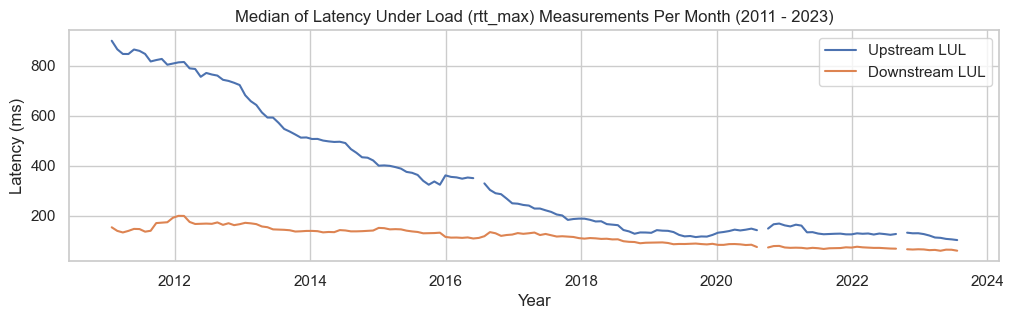

In [32]:
# Plot
sns.set_theme(style="whitegrid")
#sns.lineplot(df)
#plt.plot(df, color="blue", label="PC99")
plt.figure(figsize=(12,3))
plt.plot(up_df, label="Upstream LUL")
plt.plot(down_df, label="Downstream LUL")
plt.ylabel('Latency (ms)')
plt.xlabel('Year')
plt.title('Median of Latency Under Load (rtt_max) Measurements Per Month (2011 - 2023)')
plt.legend(loc="best")
plt.xlabel('Year')
plt.show()

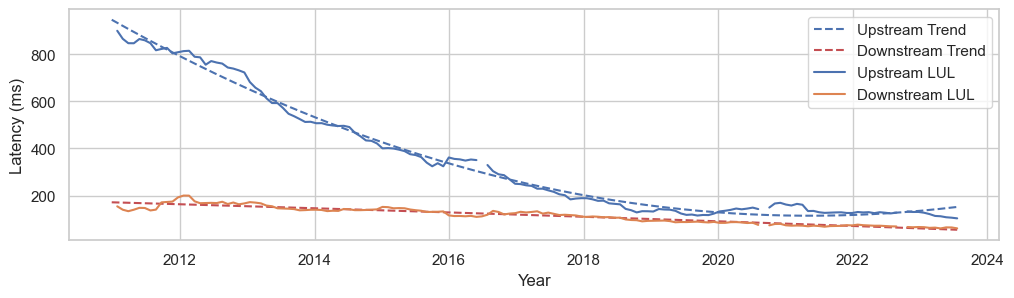

In [34]:
x_dates = up_df.index
x_num = dates.date2num(x_dates)
up_y = up_df['Upstream LUL']
down_y = down_df['Downstream LUL']
up_idx = np.isfinite(up_y) & np.isfinite(x_num)
down_idx = np.isfinite(down_y) & np.isfinite(x_num)

# Calculate fit line
up_trend = np.polyfit(x_num[up_idx], up_y[up_idx], 2)
up_fit = np.poly1d(up_trend)

down_trend = np.polyfit(x_num[down_idx], down_y[down_idx], 2)
down_fit = np.poly1d(down_trend)

# Not really necessary to convert the values back into dates
#but added as a demonstration in case one wants to plot non-linear curves
x_fit = np.linspace(x_num.min(), x_num.max())
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12,3))
plt.plot(dates.num2date(x_fit), up_fit(x_fit), "b--", label="Upstream Trend")
plt.plot(dates.num2date(x_fit), down_fit(x_fit), "r--", label="Downstream Trend")
plt.plot(up_df, label="Upstream LUL")
plt.plot(down_df, label="Downstream LUL")
plt.ylabel('Latency (ms)')
plt.xlabel('Year')
# plt.title('Median of Latency Under Load (rtt_max) Measurements Per Month (2011 - 2023)')
plt.legend(loc="best")
plt.xlabel('Year')

# And show
plt.show()

## Figure 6: Median of downstream LUL by technology

In [40]:
df = pd.read_csv('data/Downstream LUL over the years by technology - rtt_max.csv')
df['dtime per 30 days'] = pd.to_datetime(df['dtime per 30 days'], format='%Y-%m-%d')
df.head()

,Top 3 values of operator_technology,dtime per 30 days,Median Latency (ms)
0,Cable,2010-12-27,NaN
1,Cable,2011-01-26,130.779
2,Cable,2011-02-25,105.246
3,Cable,2011-03-27,99.597
4,Cable,2011-04-26,100.260


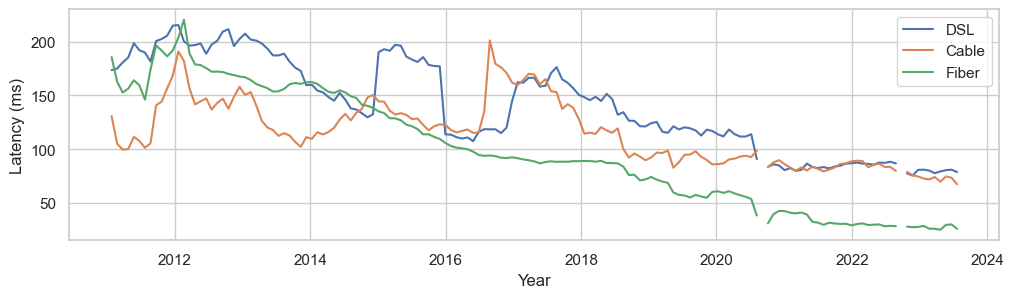

In [41]:
# General plot again
plt.figure(figsize=(12,3))
sns.set_theme(style="whitegrid")

for tech in ["DSL", "Cable", "Fiber"]:
    temp_df = df[df["Top 3 values of operator_technology"] == tech]
    x_dates = temp_df["dtime per 30 days"]
    x_num = dates.date2num(x_dates)
    y = temp_df['Median Latency (ms)']
    idx = np.isfinite(y) & np.isfinite(x_num)
    x_fit = np.linspace(x_num.min(), x_num.max())

    # plt.plot(dates.num2date(x_fit), fit(x_fit), "r--", label=f"{tech} Trend")
    plt.plot(x_dates, y, label=f"{tech}")

plt.ylabel('Latency (ms)')
plt.xlabel('Year')
# plt.title(f"Median of Downstream LUL (rtt_max) Measurements Per Month (2011 - 2023) by technology")
plt.legend(loc="best")
# And show
plt.show()

In [36]:
def plot_median_lul_by_tech(tech):
    temp_df = df[df["Top 3 values of operator_technology"] == tech]
    x_dates = temp_df["dtime per 30 days"]
    x_num = dates.date2num(x_dates)
    y = temp_df['Median Latency (ms)']
    idx = np.isfinite(y) & np.isfinite(x_num)

    # Calculate fit line
    trend = np.polyfit(x_num[idx], y[idx], 3)
    fit = np.poly1d(trend)

    # General plot again
    plt.figure(figsize=(12,3))

    x_fit = np.linspace(x_num.min(), x_num.max())
    sns.set_theme(style="whitegrid")
    plt.plot(dates.num2date(x_fit), fit(x_fit), "r--", label="Trend")
    plt.plot(x_dates, y, label="Median latency")
    plt.ylabel('Latency (ms)')
    plt.xlabel('Year')
    plt.title(f"Median of Downstream LUL (rtt_max) Measurements Per Month (2011 - 2023) for {tech}")
    plt.legend(loc="best")
    plt.xlabel('Year')

    # And show
    plt.show()

### Cable

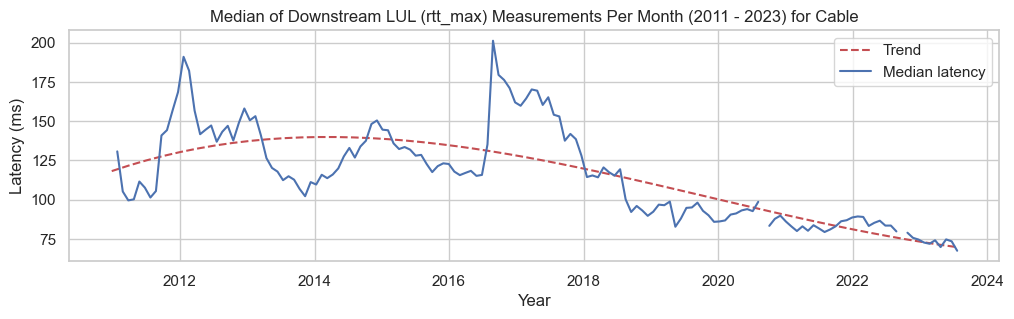

In [37]:
plot_median_lul_by_tech("Cable")

### Fiber

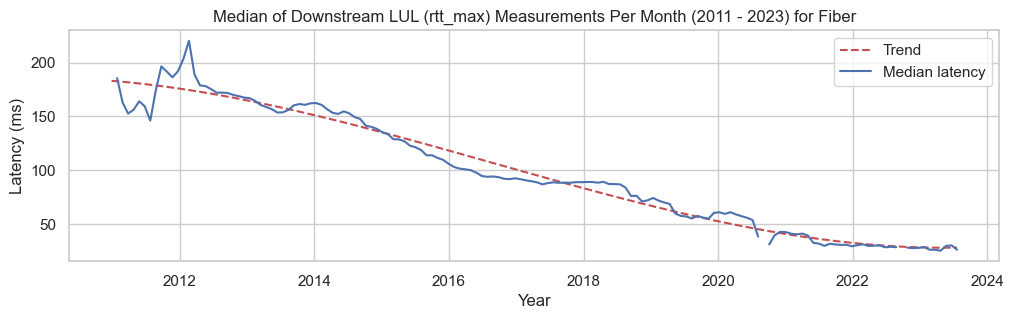

In [38]:
plot_median_lul_by_tech("Fiber")

### DSL

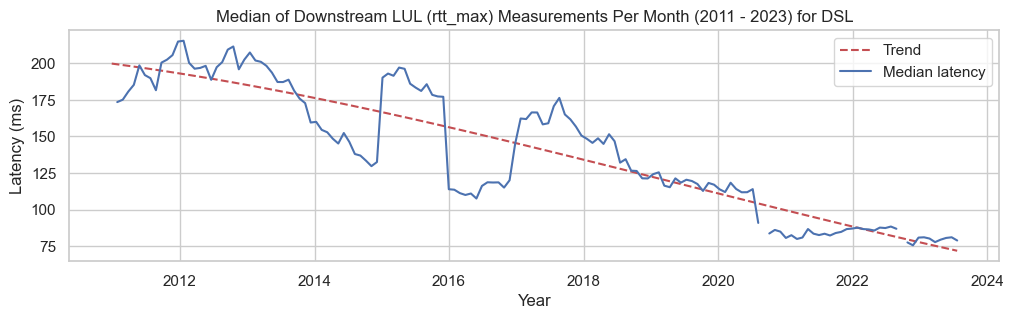

In [39]:
plot_median_lul_by_tech("DSL")

## Figure 7: Median of upstream LUL by technology

In [42]:
df = pd.read_csv('data/Upstream LUL over the years by technology - rtt_max.csv')
df['dtime per 30 days'] = pd.to_datetime(df['dtime per 30 days'], format='%Y-%m-%d')
df['Median Latency (ms)'] = df['Median Latency (ms)'].str.replace(",","").astype(float)
df.head()

,Top 3 values of operator_technology,dtime per 30 days,Median Latency (ms)
0,Cable,2010-12-27,NaN
1,Cable,2011-01-26,903.042
2,Cable,2011-02-25,825.902
3,Cable,2011-03-27,799.604
4,Cable,2011-04-26,802.219


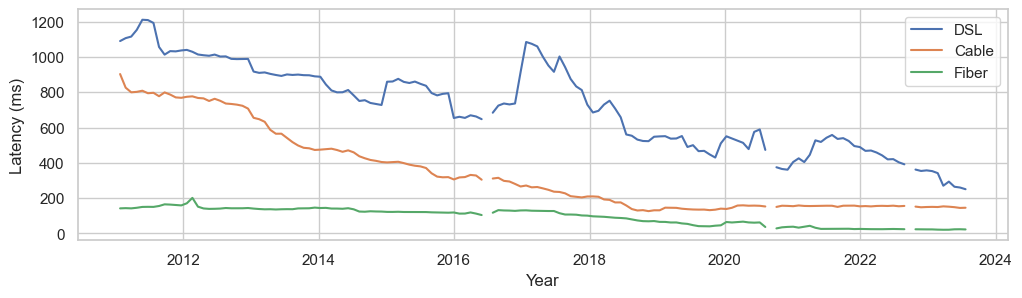

In [43]:
# General plot again
plt.figure(figsize=(12,3))
sns.set_theme(style="whitegrid")

for tech in ["DSL", "Cable", "Fiber"]:
    temp_df = df[df["Top 3 values of operator_technology"] == tech]
    x_dates = temp_df["dtime per 30 days"]
    x_num = dates.date2num(x_dates)
    y = temp_df['Median Latency (ms)']
    idx = np.isfinite(y) & np.isfinite(x_num)
    x_fit = np.linspace(x_num.min(), x_num.max())

    # plt.plot(dates.num2date(x_fit), fit(x_fit), "r--", label=f"{tech} Trend")
    plt.plot(x_dates, y, label=f"{tech}")

plt.ylabel('Latency (ms)')
plt.xlabel('Year')
# plt.title(f"Median of Downstream LUL (rtt_max) Measurements Per Month (2011 - 2023) by technology")
plt.legend(loc="best")
# And show
plt.show()

In [48]:
def plot_median_lul_by_tech(tech):
    temp_df = df[df["Top 3 values of operator_technology"] == tech]
    x_dates = temp_df["dtime per 30 days"]
    x_num = dates.date2num(x_dates)
    y = temp_df['Median Latency (ms)']
    idx = np.isfinite(y) & np.isfinite(x_num)

    # Calculate fit line
    trend = np.polyfit(x_num[idx], y[idx], 3)
    fit = np.poly1d(trend)

    # General plot again
    plt.figure(figsize=(12,3))

    x_fit = np.linspace(x_num.min(), x_num.max())
    sns.set_theme(style="whitegrid")
    plt.plot(dates.num2date(x_fit), fit(x_fit), "b--", label="Trend")
    plt.plot(x_dates, y, label="Median latency")
    plt.ylabel('Latency (ms)')
    plt.xlabel('Year')
    plt.title(f"Median of upstream LUL (rtt_max) Measurements Per Month (2011 - 2023) for {tech}")
    plt.legend(loc="best")
    plt.xlabel('Year')

    # And show
    plt.show()

### Cable

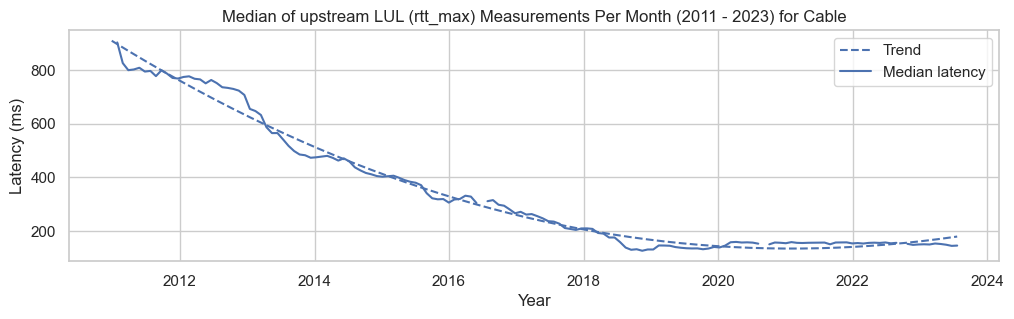

In [49]:
plot_median_lul_by_tech("Cable")

### Fiber

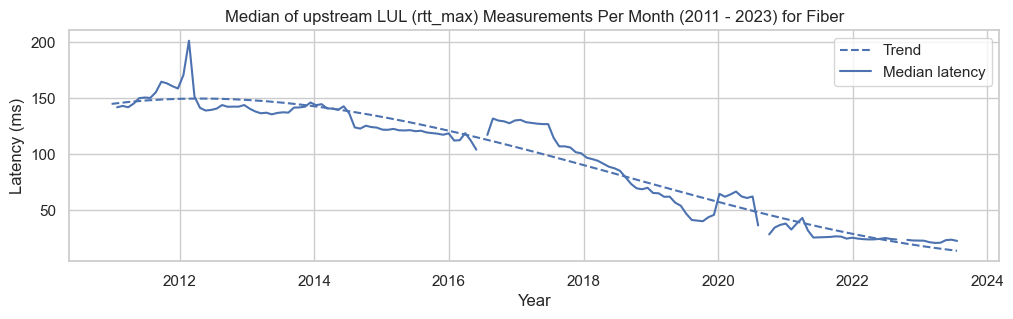

In [50]:
plot_median_lul_by_tech("Fiber")

### DSL

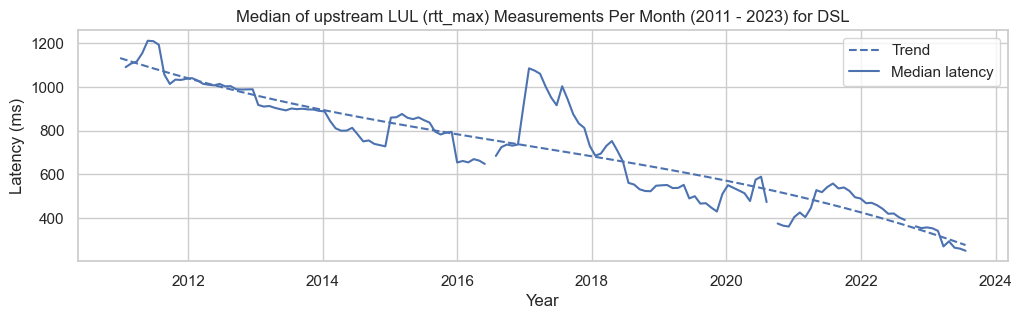

In [51]:
plot_median_lul_by_tech("DSL")

## Figure 8: 95th percentile of latency under load

In [54]:
up_df = pd.read_csv('data/LUL_upstream_95pc_rtt_max.csv')
down_df = pd.read_csv('data/LUL_downstream_95pc_rtt_max.csv')
up_df['dtime per 30 days'] = pd.to_datetime(up_df['dtime per 30 days'], format='%Y-%m-%d')
down_df['dtime per 30 days'] = pd.to_datetime(down_df['dtime per 30 days'], format='%Y-%m-%d')
down_df['Downstream LUL'] = down_df['Downstream LUL'].str.replace(",","").astype(float)
up_df['Upstream LUL'] = up_df['Upstream LUL'].str.replace(",","").astype(float)


# Convert time series with index Month
up_df.index = up_df['dtime per 30 days']
down_df.index = down_df['dtime per 30 days']
del up_df['dtime per 30 days']
del down_df['dtime per 30 days']
print(up_df.head())
print(down_df.head())

                   Upstream LUL
dtime per 30 days              
2011-12-22             2222.927
2012-01-21             2209.962
2012-02-20             2205.582
2012-03-21             2173.747
2012-04-20             2164.544
                   Downstream LUL
dtime per 30 days                
2011-12-22               1338.028
2012-01-21               1444.847
2012-02-20               1380.341
2012-03-21               1316.748
2012-04-20               1247.911


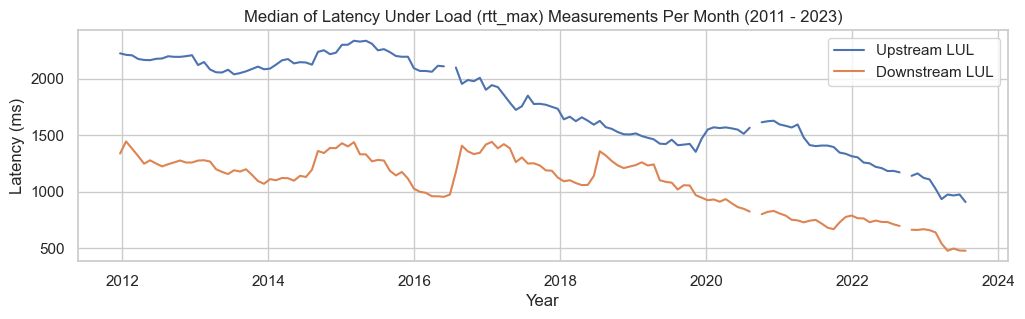

In [55]:
# Plot
sns.set_theme(style="whitegrid")
#sns.lineplot(df)
#plt.plot(df, color="blue", label="PC99")
plt.figure(figsize=(12,3))
plt.plot(up_df, label="Upstream LUL")
plt.plot(down_df, label="Downstream LUL")
plt.ylabel('Latency (ms)')
plt.xlabel('Year')
plt.title('Median of Latency Under Load (rtt_max) Measurements Per Month (2011 - 2023)')
plt.legend(loc="best")
plt.xlabel('Year')
plt.show()

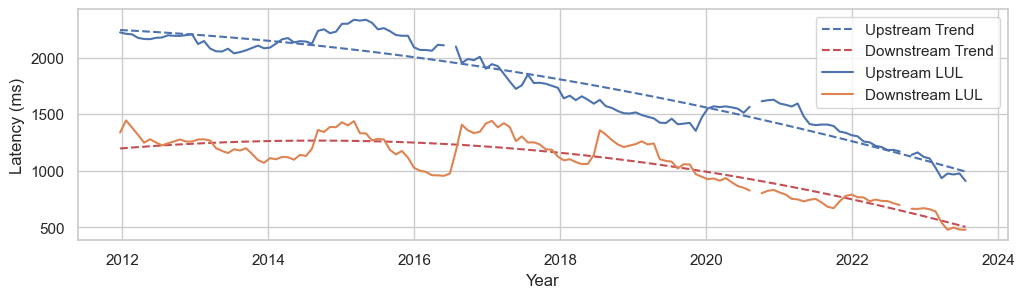

In [56]:
x_dates = up_df.index
x_num = dates.date2num(x_dates)
up_y = up_df['Upstream LUL']
down_y = down_df['Downstream LUL']
up_idx = np.isfinite(up_y) & np.isfinite(x_num)
down_idx = np.isfinite(down_y) & np.isfinite(x_num)

# Calculate fit line
up_trend = np.polyfit(x_num[up_idx], up_y[up_idx], 2)
up_fit = np.poly1d(up_trend)

down_trend = np.polyfit(x_num[down_idx], down_y[down_idx], 2)
down_fit = np.poly1d(down_trend)

# Not really necessary to convert the values back into dates
#but added as a demonstration in case one wants to plot non-linear curves
x_fit = np.linspace(x_num.min(), x_num.max())
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12,3))
plt.plot(dates.num2date(x_fit), up_fit(x_fit), "b--", label="Upstream Trend")
plt.plot(dates.num2date(x_fit), down_fit(x_fit), "r--", label="Downstream Trend")
plt.plot(up_df, label="Upstream LUL")
plt.plot(down_df, label="Downstream LUL")
plt.ylabel('Latency (ms)')
plt.xlabel('Year')
# plt.title('Median of Latency Under Load (rtt_max) Measurements Per Month (2011 - 2023)')
plt.legend(loc="best")
plt.xlabel('Year')

# And show
plt.show()

## Figure 9: 95th percentile of downstream LUL by technology

In [57]:
df = pd.read_csv('data/95th Percentile of rtt_max over time - Downstream LUL.csv')
df['time per 30 days'] = pd.to_datetime(df['time per 30 days'], format='%Y-%m-%d')
df['Latency'] = df['Latency'].str.replace(",","").astype(float)
df.head()

,Top 3 values of operator_technology,time per 30 days,Latency
0,Cable,2011-12-22,1078.128
1,Cable,2012-01-21,1213.429
2,Cable,2012-02-20,1147.298
3,Cable,2012-03-21,1118.252
4,Cable,2012-04-20,1094.866


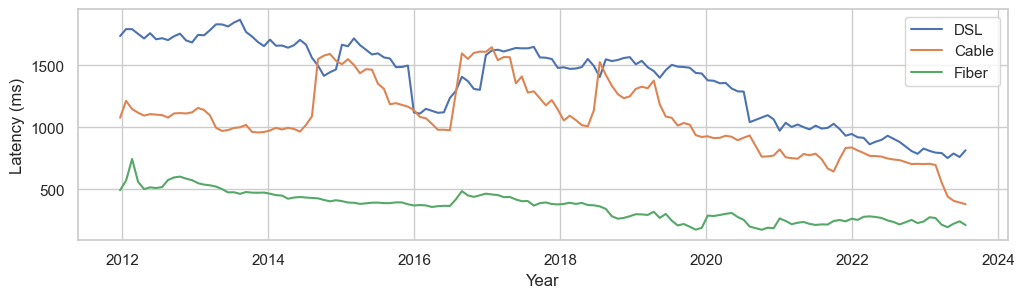

In [59]:
# General plot again
plt.figure(figsize=(12,3))
sns.set_theme(style="whitegrid")

for tech in ["DSL", "Cable", "Fiber"]:
    temp_df = df[df["Top 3 values of operator_technology"] == tech]
    x_dates = temp_df["time per 30 days"]
    x_num = dates.date2num(x_dates)
    y = temp_df['Latency']
    idx = np.isfinite(y) & np.isfinite(x_num)
    x_fit = np.linspace(x_num.min(), x_num.max())

    # plt.plot(dates.num2date(x_fit), fit(x_fit), "r--", label=f"{tech} Trend")
    plt.plot(x_dates, y, label=f"{tech}")

plt.ylabel('Latency (ms)')
plt.xlabel('Year')
# plt.title(f"Median of Downstream LUL (rtt_max) Measurements Per Month (2011 - 2023) by technology")
plt.legend(loc="best")
# And show
plt.show()

In [60]:
def plot_95pc_lul_by_tech(tech):
    temp_df = df[df["Top 3 values of operator_technology"] == tech]
    x_dates = temp_df["time per 30 days"]
    x_num = dates.date2num(x_dates)
    y = temp_df['Latency']
    idx = np.isfinite(y) & np.isfinite(x_num)

    # Calculate fit line
    trend = np.polyfit(x_num[idx], y[idx], 3)
    fit = np.poly1d(trend)

    # General plot again
    plt.figure(figsize=(12,3))

    x_fit = np.linspace(x_num.min(), x_num.max())
    sns.set_theme(style="whitegrid")
    plt.plot(dates.num2date(x_fit), fit(x_fit), "r--", label="Trend")
    plt.plot(x_dates, y, label="Median latency")
    plt.ylabel('Latency (ms)')
    plt.xlabel('Year')
    plt.title(f"95th percentile of Downstream LUL by technology (2012 – 2023) for {tech}")
    plt.legend(loc="best")
    plt.xlabel('Year')

    # And show
    plt.show()

### Cable

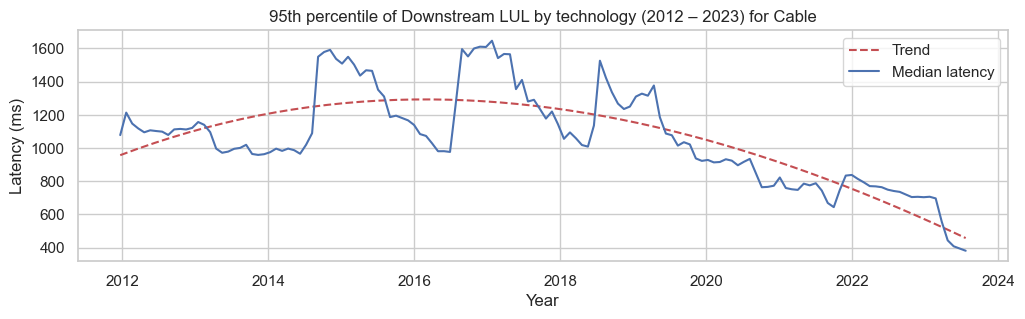

In [61]:
plot_95pc_lul_by_tech("Cable")

### Fiber

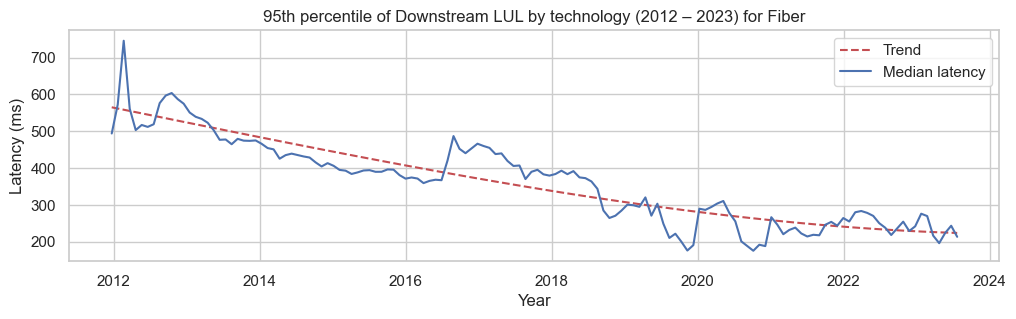

In [62]:
plot_95pc_lul_by_tech("Fiber")

### DSL

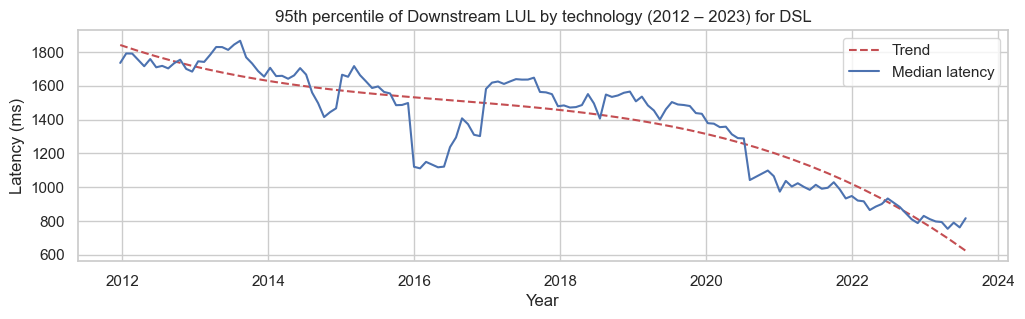

In [63]:
plot_95pc_lul_by_tech("DSL")

## Figure 10: 95th percentile of upstream LUL by technology

In [64]:
df = pd.read_csv('data/95th Percentile of rtt_max over time - Upstream LUL.csv')
df['time per 30 days'] = pd.to_datetime(df['time per 30 days'], format='%Y-%m-%d')
df['Latency'] = df['Latency'].str.replace(",","").astype(float)
df.head()

,Top 3 values of operator_technology,time per 30 days,Latency
0,Cable,2011-12-22,2179.143
1,Cable,2012-01-21,2181.383
2,Cable,2012-02-20,2196.523
3,Cable,2012-03-21,2134.460
4,Cable,2012-04-20,2145.526


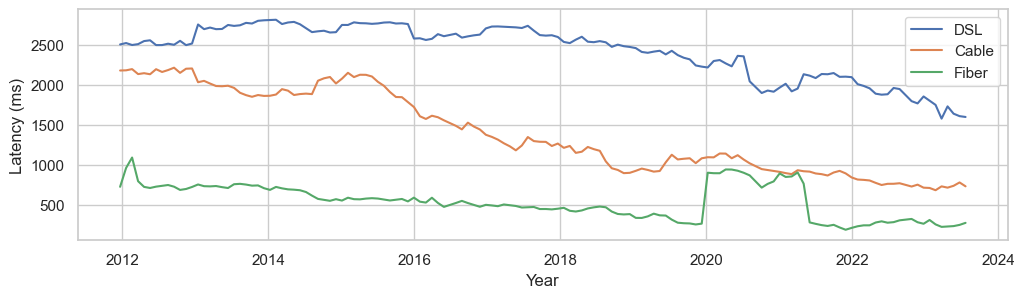

In [65]:
# General plot again
plt.figure(figsize=(12,3))
sns.set_theme(style="whitegrid")

for tech in ["DSL", "Cable", "Fiber"]:
    temp_df = df[df["Top 3 values of operator_technology"] == tech]
    x_dates = temp_df["time per 30 days"]
    x_num = dates.date2num(x_dates)
    y = temp_df['Latency']
    idx = np.isfinite(y) & np.isfinite(x_num)
    x_fit = np.linspace(x_num.min(), x_num.max())

    # plt.plot(dates.num2date(x_fit), fit(x_fit), "r--", label=f"{tech} Trend")
    plt.plot(x_dates, y, label=f"{tech}")

plt.ylabel('Latency (ms)')
plt.xlabel('Year')
# plt.title(f"Median of Downstream LUL (rtt_max) Measurements Per Month (2011 - 2023) by technology")
plt.legend(loc="best")
# And show
plt.show()

In [66]:
def plot_95pc_up_lul_by_tech(tech):
    temp_df = df[df["Top 3 values of operator_technology"] == tech]
    x_dates = temp_df["time per 30 days"]
    x_num = dates.date2num(x_dates)
    y = temp_df['Latency']
    idx = np.isfinite(y) & np.isfinite(x_num)

    # Calculate fit line
    trend = np.polyfit(x_num[idx], y[idx], 3)
    fit = np.poly1d(trend)

    # General plot again
    plt.figure(figsize=(12,3))

    x_fit = np.linspace(x_num.min(), x_num.max())
    sns.set_theme(style="whitegrid")
    plt.plot(dates.num2date(x_fit), fit(x_fit), "r--", label="Trend")
    plt.plot(x_dates, y, label="Median latency")
    plt.ylabel('Latency (ms)')
    plt.xlabel('Year')
    plt.title(f"95th percentile of Upstream LUL by technology (2012 – 2023) for {tech}")
    plt.legend(loc="best")
    plt.xlabel('Year')

    # And show
    plt.show()

### Cable

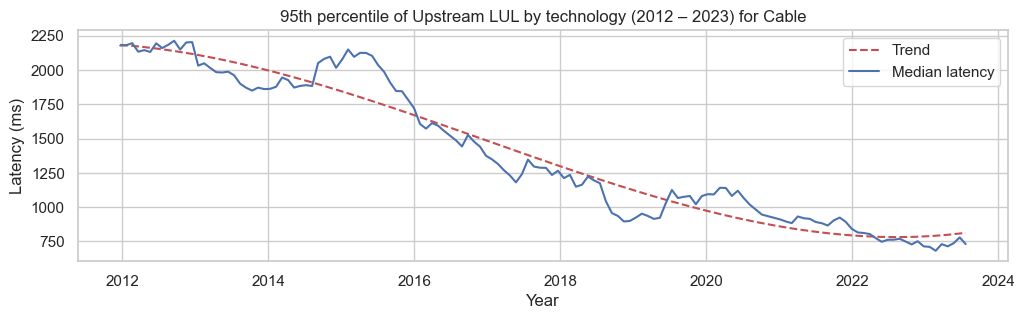

In [67]:
plot_95pc_up_lul_by_tech("Cable")

### Fiber

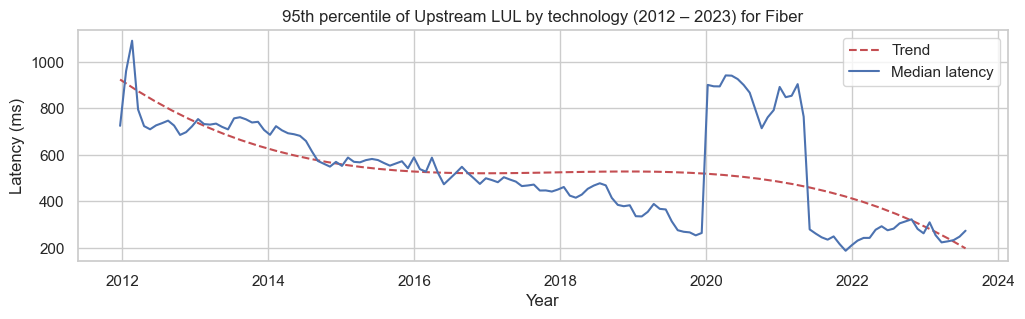

In [68]:
plot_95pc_up_lul_by_tech("Fiber")

### DSL

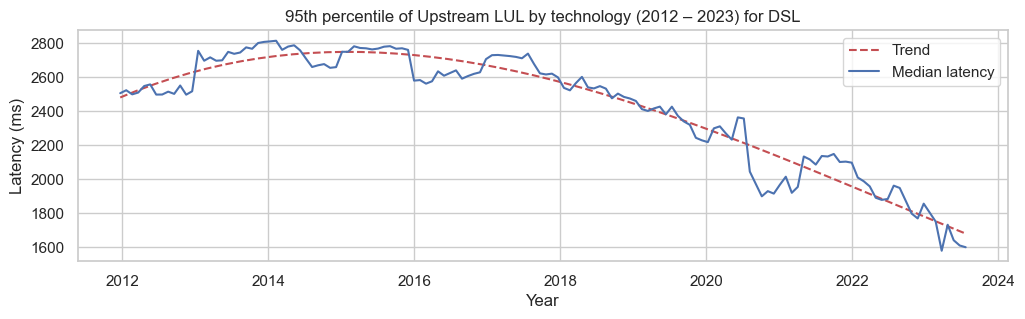

In [69]:
plot_95pc_up_lul_by_tech("DSL")

## Figure 11: CDF of Downstream LUL

In [14]:
all_info = []
with open("data/CDF of Downstream LUL.json", "r") as f:
    data = json.load(f)
for tech_data in data.get("aggregations", '').get("terms", '').get("buckets", ''):
    for pc_info in tech_data.get("cdf", '').get("values", ''):
        all_info.append([tech_data.get("key", ""), pc_info.get("key", ""), pc_info.get("value", "")])

df = pd.DataFrame(all_info, columns=["technology", "percentiles", "latency"])
df["latency"] = df["latency"] / 1000


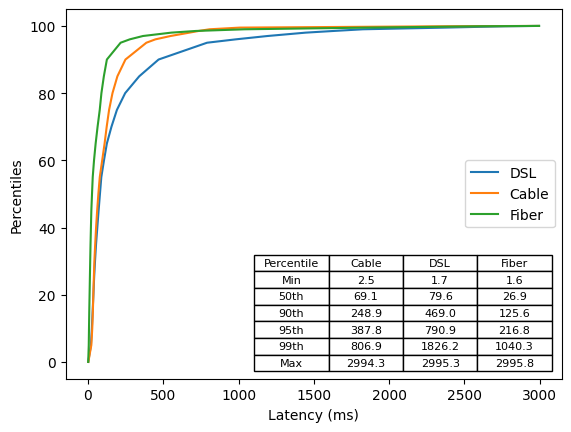

In [15]:
new_df = df[df.percentiles.isin([0, 50, 90, 95, 99, 100])]
new_df = new_df.sort_values(by="technology", ascending=True)
new_df = new_df.round({'latency': 1})

table_data = [
    ['Min'] + new_df[new_df["percentiles"]==0]["latency"].tolist(),
    ['50th'] + new_df[new_df["percentiles"]==50]["latency"].tolist(),
    ['90th'] + new_df[new_df["percentiles"]==90]["latency"].tolist(),
    ['95th'] + new_df[new_df["percentiles"]==95]["latency"].tolist(),
    ['99th'] + new_df[new_df["percentiles"]==99]["latency"].tolist(),
    ['Max'] + new_df[new_df["percentiles"]==100]["latency"].tolist(),
]

# General plot again
# fig, ax1 = plt.figure(figsize=(15,7))
fig, ax1 = plt.subplots()
# fig.set_figure(figsize=(15,7))
# sns.set_theme(style="whitegrid")

for tech in ["DSL", "Cable", "Fiber"]:
    temp_df = df[df["technology"] == tech]
    x_num = temp_df["latency"]
    y = temp_df['percentiles']
    idx = np.isfinite(y) & np.isfinite(x_num)
    x_fit = np.linspace(x_num.min(), x_num.max())
    ax1.plot(x_num, y, label=f"{tech}")

ax1.set_ylabel('Percentiles')
ax1.set_xlabel('Latency (ms)')
ax1.ticklabel_format(style='plain') # prevent scientific notation
# plt.title(f"Median of Idle Latency Measurements Per Month by Technology (2011 – 2023)")

# Create the table within the plot
table = ax1.table(
    cellText=table_data,
    # colLabels=['Percentile', 'Min', '50th', '90th', '95th', '99th', '99.9th', 'Max'],
    colWidths=[0.15, 0.15, 0.15, 0.15],
    colLabels=['Percentile', 'Cable', 'DSL', 'Fiber'],
    loc='lower right',
    cellLoc='center'
)
table.scale(1, 1)
table.auto_set_font_size(False)  # Prevent automatic font resizing
table.set_fontsize(8)  # Adjust font size as needed

plt.legend(loc="center right")
# And show
plt.show()

## Figure 12: CDF of Upstream LUL

In [12]:
all_info = []
with open("data/CDF of Upstream LUL.json", "r") as f:
    data = json.load(f)
for tech_data in data.get("aggregations", '').get("terms", '').get("buckets", ''):
    for pc_info in tech_data.get("cdf", '').get("values", ''):
        all_info.append([tech_data.get("key", ""), pc_info.get("key", ""), pc_info.get("value", "")])

df = pd.DataFrame(all_info, columns=["technology", "percentiles", "latency"])
df["latency"] = df["latency"] / 1000

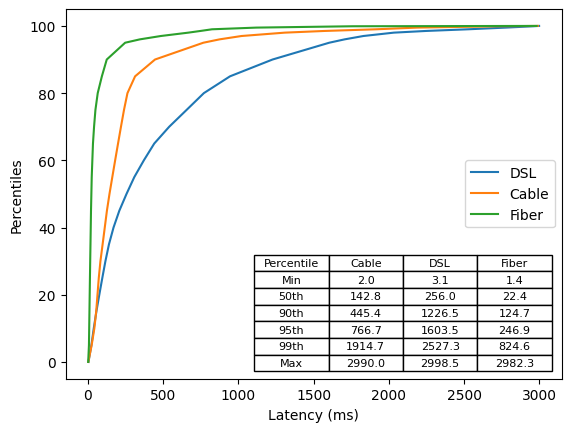

In [13]:
new_df = df[df.percentiles.isin([0, 50, 90, 95, 99, 100])]
new_df = new_df.sort_values(by="technology", ascending=True)
new_df = new_df.round({'latency': 1})

table_data = [
    ['Min'] + new_df[new_df["percentiles"]==0]["latency"].tolist(),
    ['50th'] + new_df[new_df["percentiles"]==50]["latency"].tolist(),
    ['90th'] + new_df[new_df["percentiles"]==90]["latency"].tolist(),
    ['95th'] + new_df[new_df["percentiles"]==95]["latency"].tolist(),
    ['99th'] + new_df[new_df["percentiles"]==99]["latency"].tolist(),
    ['Max'] + new_df[new_df["percentiles"]==100]["latency"].tolist(),
]

# General plot again
# fig, ax1 = plt.figure(figsize=(15,7))
fig, ax1 = plt.subplots()
# fig.set_figure(figsize=(15,7))
# sns.set_theme(style="whitegrid")

for tech in ["DSL", "Cable", "Fiber"]:
    temp_df = df[df["technology"] == tech]
    x_num = temp_df["latency"]
    y = temp_df['percentiles']
    idx = np.isfinite(y) & np.isfinite(x_num)
    x_fit = np.linspace(x_num.min(), x_num.max())
    ax1.plot(x_num, y, label=f"{tech}")

ax1.set_ylabel('Percentiles')
ax1.set_xlabel('Latency (ms)')
ax1.ticklabel_format(style='plain') # prevent scientific notation
# plt.title(f"Median of Idle Latency Measurements Per Month by Technology (2011 – 2023)")

# Create the table within the plot
table = ax1.table(
    cellText=table_data,
    # colLabels=['Percentile', 'Min', '50th', '90th', '95th', '99th', '99.9th', 'Max'],
    colWidths=[0.15, 0.15, 0.15, 0.15],
    colLabels=['Percentile', 'Cable', 'DSL', 'Fiber'],
    loc='lower right',
    cellLoc='center'
)
table.scale(1, 1)
table.auto_set_font_size(False)  # Prevent automatic font resizing
table.set_fontsize(8)  # Adjust font size as needed

plt.legend(loc="center right")
# And show
plt.show()

## Figure 13: Percentage of data less than 100ms for Downstream LUL

In [2]:
df = pd.read_csv('data/Percentage of data less than 100 ms - downstream LUL.csv')
df['dtime per 30 days'] = pd.to_datetime(df['dtime per 30 days'], format='%Y-%m-%d')
df['Percentage'] = df['Percentage'].str.replace("%","").astype(float)
df.head()

,Top 3 values of operator_technology,dtime per 30 days,Percentage
0,Cable,2010-12-27,NaN
1,Cable,2011-01-26,42.97
2,Cable,2011-02-25,49.40
3,Cable,2011-03-27,51.07
4,Cable,2011-04-26,50.95


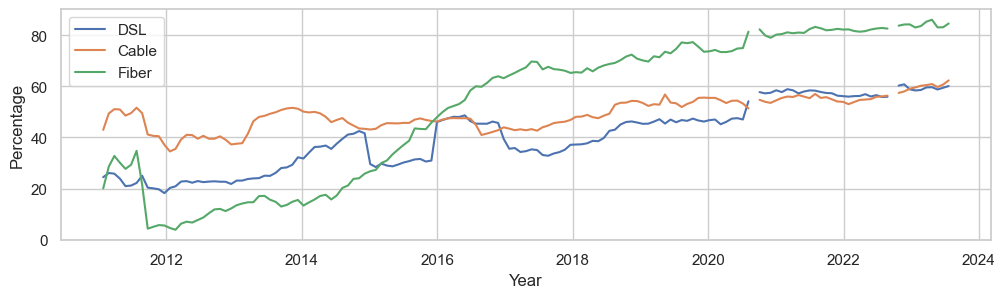

In [3]:
# General plot again
plt.figure(figsize=(12,3))
sns.set_theme(style="whitegrid")

for tech in ["DSL", "Cable", "Fiber"]:
    temp_df = df[df["Top 3 values of operator_technology"] == tech]
    x_dates = temp_df["dtime per 30 days"]
    x_num = dates.date2num(x_dates)
    y = temp_df['Percentage']
    idx = np.isfinite(y) & np.isfinite(x_num)
    x_fit = np.linspace(x_num.min(), x_num.max())

    # Calculate fit line
    # trend = np.polyfit(x_num[idx], y[idx], 2)
    # fit = np.poly1d(trend)


    # plt.plot(dates.num2date(x_fit), fit(x_fit), "r--", label=f"{tech} Trend")
    plt.plot(x_dates, y, label=f"{tech}")

plt.ylabel('Percentage')
plt.xlabel('Year')
# plt.title(f"Median of Idle Latency Measurements Per Month by Technology (2011 – 2023)")
plt.legend(loc="best")
# And show
plt.show()

## Figure 14: Percentage of data less than 100ms for Upstream LUL

In [4]:
df = pd.read_csv('data/Percentage of data less than 100 ms - upstream LUL.csv')
df['dtime per 30 days'] = pd.to_datetime(df['dtime per 30 days'], format='%Y-%m-%d')
df['Percentage'] = df['Percentage'].str.replace("%","").astype(float)
df.head()

,Top 3 values of operator_technology,dtime per 30 days,Percentage
0,Cable,2010-12-27,NaN
1,Cable,2011-01-26,5.82
2,Cable,2011-02-25,10.37
3,Cable,2011-03-27,11.34
4,Cable,2011-04-26,9.32


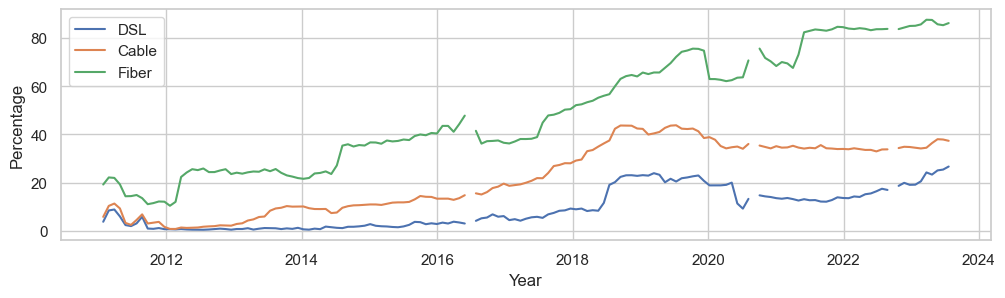

In [5]:
# General plot again
plt.figure(figsize=(12,3))
sns.set_theme(style="whitegrid")

for tech in ["DSL", "Cable", "Fiber"]:
    temp_df = df[df["Top 3 values of operator_technology"] == tech]
    x_dates = temp_df["dtime per 30 days"]
    x_num = dates.date2num(x_dates)
    y = temp_df['Percentage']
    idx = np.isfinite(y) & np.isfinite(x_num)
    x_fit = np.linspace(x_num.min(), x_num.max())

    # Calculate fit line
    # trend = np.polyfit(x_num[idx], y[idx], 2)
    # fit = np.poly1d(trend)


    # plt.plot(dates.num2date(x_fit), fit(x_fit), "r--", label=f"{tech} Trend")
    plt.plot(x_dates, y, label=f"{tech}")

plt.ylabel('Percentage')
plt.xlabel('Year')
# plt.title(f"Median of Idle Latency Measurements Per Month by Technology (2011 – 2023)")
plt.legend(loc="best")
# And show
plt.show()

## Figure 15: Moving averages for July 2023

In [21]:
avg_df = pd.read_csv('data/Moving_Average_average.csv')
pc_df = pd.read_csv('data/Moving_Average_95pc.csv')
# avg_df['dtime_local per 10 minutes'] = pd.to_datetime(avg_df['dtime_local per 10 minutes'], format='%H:%M', exact=True).dt.strftime('%H:%M')
# pc_df['dtime_local per 10 minutes'] = pd.to_datetime(pc_df['dtime_local per 10 minutes'], format='%H:%M', exact=True).dt.strftime('%H:%M')
avg_df['dtime_local per 10 minutes'] = pd.to_datetime(avg_df['dtime_local per 10 minutes'], unit='ms')
pc_df['dtime_local per 10 minutes'] = pd.to_datetime(pc_df['dtime_local per 10 minutes'], unit='ms')
# pc_df['95th percentile of rtt_max'] = pc_df['95th percentile of rtt_max'].str.replace(",","").astype(float)
# avg_df['Average of rtt_max'] = avg_df['Average of rtt_max'].str.replace(",","").astype(float)


# Convert time series with index Month
avg_df.index = avg_df['dtime_local per 10 minutes']
pc_df.index = pc_df['dtime_local per 10 minutes']
del avg_df['dtime_local per 10 minutes']
del pc_df['dtime_local per 10 minutes']
print(avg_df.head())
print(pc_df.head())

                            Average of rtt_max
dtime_local per 10 minutes                    
2023-07-03 00:00:00                        NaN
2023-07-03 00:10:00                  36.911665
2023-07-03 00:20:00                  35.765286
2023-07-03 00:30:00                  35.534863
2023-07-03 00:40:00                  34.826882
                            95th percentile of rtt_max
dtime_local per 10 minutes                            
2023-07-03 00:00:00                                NaN
2023-07-03 00:10:00                         109.487600
2023-07-03 00:20:00                          97.725325
2023-07-03 00:30:00                          99.749683
2023-07-03 00:40:00                          96.870287


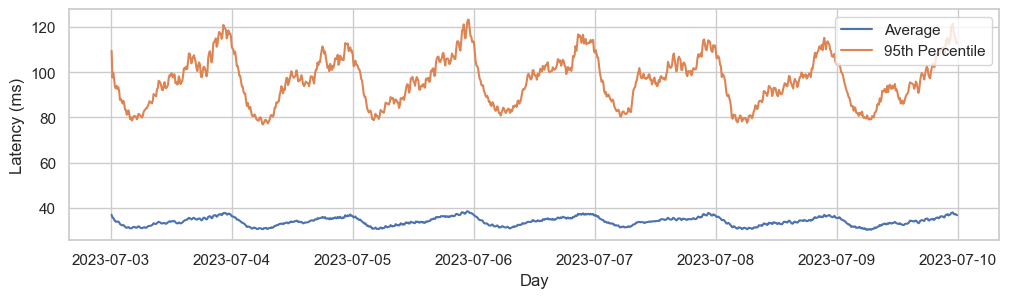

In [22]:
# Plot
sns.set_theme(style="whitegrid")
#sns.lineplot(df)
#plt.plot(df, color="blue", label="PC99")
plt.figure(figsize=(12,3))
plt.plot(avg_df, label="Average")
plt.plot(pc_df, label="95th Percentile")
plt.ylabel('Latency (ms)')
plt.xlabel('Day')
# plt.title('Median of Latency Under Load (rtt_max) Measurements Per Month (2011 - 2023)')
plt.legend(loc="best")
plt.show()